# Analyze data

In [3]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [4]:
ROOT_DIR = Path('../..')

In [6]:
df = pd.read_csv(ROOT_DIR / '.secrets' / 'raw_forum.csv')

In [8]:
df['date']

0          2022-06-30 22:32:44
1          2016-11-22 09:57:02
2          2025-03-23 07:31:21
3          2024-05-26 22:50:25
4          2024-03-19 19:37:09
                  ...         
1984818    2024-04-29 18:55:31
1984819    2024-05-31 01:01:12
1984820    2024-02-16 01:35:04
1984821    2021-03-04 21:05:51
1984822    2021-02-21 19:25:05
Name: date, Length: 1984823, dtype: object

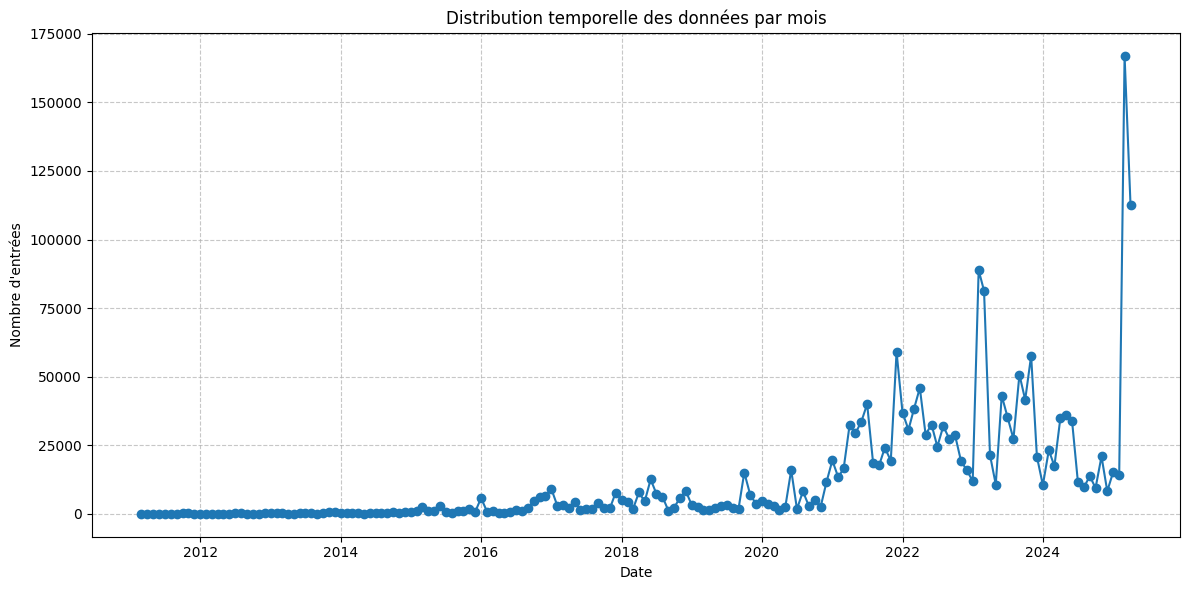

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df_monthly = df.resample('MS', on='date').size().reset_index(name='nb_evenements')

plt.figure(figsize=(12, 6))
plt.plot(df_monthly['date'], df_monthly['nb_evenements'], marker='o', linestyle='-')

plt.title('Distribution temporelle des données par mois')
plt.xlabel('Date')
plt.ylabel('Nombre d\'entrées')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

In [10]:
df_monthly.to_csv('stats_mensuelles.csv', index=False)

## Adding a soft label (generated with gpt-4o-mini)

In [5]:
from openai import OpenAI
from pathlib import Path
from time import sleep
from typing import Dict, Any, List
from concurrent.futures import ThreadPoolExecutor

class GPTPredictor():
    def __init__(self, config: Dict[str, Any]):
        self.client = None
        self.model_name = config.get("model_name", "gpt-4o-mini")
        self.api_key = config.get("api_key", None)
        self.system_prompt = config.get("system_prompt", "")
        self.prompt_template = config.get("prompt_template", "") 
        self.language = config.get("language", "fr")
        
        if self.language == "fr":
            self.expected_responses = {0 : "non-toxique", 1: "toxique"}
            self.question = "Ce message est-il toxique ?"
        else:
            self.expected_responses = {0 : "non-toxic", 1: "toxic"}
            self.question = "Is this message toxic?"
            
        self.max_retries = config.get("max_retries", 5)
        self.delay_base = config.get("delay_base", 0.5)
        self.max_workers = config.get("parallel_requests", 10)

    def initialise_predictor(self):
        if not self.api_key:
            raise ValueError("OpenAI API key is missing.")
        try:
            self.client = OpenAI(api_key=self.api_key)
            print(f"OpenAI client initialized for model: {self.model_name} with api key : {self.api_key[:8]}****{self.api_key[-4:]}")
        except Exception as e:
            raise RuntimeError(f"Failed to initialize OpenAI client: {e}")

    def generate_messages(self, text: str) -> List[Dict[str, str]]:
        input_text = f"{self.prompt_template} « {text} »\n{self.question}\n"
        return [
            {"role": "system", "content": self.system_prompt},
            {"role": "user", "content": input_text}
        ]
    
    def predict(self, text: str) -> int:
        messages = self.generate_messages(text)
        
        for attempt in range(self.max_retries):
            try:
                response = self.client.chat.completions.create(
                    model=self.model_name,
                    messages=messages,
                    temperature=0,
                    max_tokens=10 
                )                
                result = response.choices[0].message.content.strip().lower()
                if self.expected_responses[0] in result:
                    return 0
                elif self.expected_responses[1] in result:
                    return 1
                else:
                    return result
            except Exception as e:
                sleep(self.delay_base * (2 ** attempt))
                print(f"DEBUG ERROR: {type(e).__name__}: {e}")
                continue 
        return "Error"

    def predict_batch(self, texts: List[str]) -> List[int]:
        if not self.client:
            self.initialise_predictor()

        with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            results = list(executor.map(self.predict, texts))
            
        return results

In [6]:
from dotenv import load_dotenv
import os
load_dotenv(ROOT_DIR / '.secrets' / '.env')

# set proxy
os.environ['http_proxy'] = os.getenv("HTTP_PROXY", "")
os.environ['https_proxy'] = os.getenv("HTTPS_PROXY", "")

predictor = GPTPredictor({
    "api_key": os.getenv("OPENAI_API"),
    "model_name": "gpt-4o-mini",
    "language": "fr",
    "prompt_template": Path("../../benchmarking/prompts/simple_toxicity_french.txt").read_text(),
    "system_prompt": Path("../../benchmarking/prompts/system_prompt_french.txt").read_text(),
    "max_retries": 5,
    "delay_base": 0.5,
    "parallel_requests": 10
})

In [7]:
df = pd.read_csv("anonymous_forum_prioritized_annotated.csv")

/tmp/ipykernel_3269537/1237320150.py:1: DtypeWarning: Columns (7,8,9,10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("anonymous_forum_prioritized_annotated.csv")


In [8]:
predictor.initialise_predictor()

OpenAI client initialized for model: gpt-4o-mini with api key : sk-proj-****bGoA
